### Copying images to training, validation, and test directories

In [43]:
import os, shutil

In [44]:
base_dir = 'fractures_detection'
#os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

train_fractures_dir = os.path.join(train_dir, 'fractures')
#os.mkdir(train_cats_dir)

train_non_fractures_dir = os.path.join(train_dir, 'non_fractures')
#os.mkdir(train_dogs_dir)

validation_fractures_dir = os.path.join(validation_dir, 'fractures')
#os.mkdir(validation_cats_dir)

validation_non_fractures_dir = os.path.join(validation_dir, 'non_fractures')
#os.mkdir(validation_dogs_dir)

test_fractures_dir = os.path.join(test_dir, 'fractures')
#os.mkdir(test_cats_dir)

test_non_fractures_dir = os.path.join(test_dir, 'non_fractures')
#os.mkdir(test_dogs_dir)


### sanity check, counting how many pictures are in each training split (train/validation/test)

In [45]:
print('total training fractures images:', len(os.listdir(train_fractures_dir)))
print('total training non fractures images:', len(os.listdir(train_non_fractures_dir)))

print('total validation fractures images:', len(os.listdir(validation_fractures_dir)))
print('total validation non fractures images:', len(os.listdir(validation_non_fractures_dir)))

print('total test fractures images:', len(os.listdir(test_fractures_dir)))
print('total test non fractures images:', len(os.listdir(test_non_fractures_dir)))


total training fractures images: 63
total training non fractures images: 64
total validation fractures images: 20
total validation non fractures images: 21
total test fractures images: 20
total test non fractures images: 23


### Building the network

In [46]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(250, 250, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 59, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 53824)             0         
__________

### Configuring the model for training

In [48]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

### Data preprocessing

#### Using ImageDataGenerator to read images from directories


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(250, 250),
                                                    batch_size=10, 
                                                    #classes=['fractures','non_fractures'],
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(250,250),
                                                        batch_size=10,
                                                       #classes=['fractures','non_fractures'],
                                                       class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(250,250),
                                                        batch_size=10,
                                                       #classes=['fractures','non_fractures'],
                                                       class_mode='binary')
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=15, mode='min'), 
    ModelCheckpoint(filepath='cnn_fracture_non_fracture_model_10_oct.h5', monitor='val_loss',save_best_only=True) 
]


Found 127 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


### Understanding Python generators

In [50]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (10, 250, 250, 3)
labels batch shape: (10,)


### Fitting the model using a batch generator

In [51]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=15,
                              epochs=40, 
                              validation_data = validation_generator, 
                              validation_steps=5, callbacks=callbacks_list)
#

Epoch 1/40
15/15 [==============================] - 40s 3s/step - loss: 0.9002 - acc: 0.5754 - val_loss: 0.6964 - val_acc: 0.5122
Epoch 2/40
15/15 [==============================] - 33s 2s/step - loss: 0.6891 - acc: 0.4993 - val_loss: 0.6835 - val_acc: 0.4878
Epoch 3/40
15/15 [==============================] - 30s 2s/step - loss: 0.6215 - acc: 0.6809 - val_loss: 0.6962 - val_acc: 0.5366
Epoch 4/40
15/15 [==============================] - 32s 2s/step - loss: 0.5307 - acc: 0.7837 - val_loss: 0.7055 - val_acc: 0.5610
Epoch 5/40
15/15 [==============================] - 33s 2s/step - loss: 0.4553 - acc: 0.7941 - val_loss: 0.7119 - val_acc: 0.5366
Epoch 6/40
15/15 [==============================] - 33s 2s/step - loss: 0.3703 - acc: 0.8705 - val_loss: 0.7459 - val_acc: 0.5854
Epoch 7/40
15/15 [==============================] - 40s 3s/step - loss: 0.3539 - acc: 0.8745 - val_loss: 0.7437 - val_acc: 0.5854
Epoch 8/40
15/15 [==============================] - 39s 3s/step - loss: 0.2476 - acc: 0.93

In [52]:
model.save('fractures_non_fractures_10_10_2019.h5')

In [80]:
model_saved = models.load_model('cnn_fracture_non_fracture_model_10_oct.h5')

### Displaying curves of loss and accuracy during training

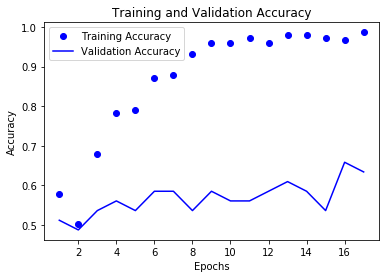

In [53]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()




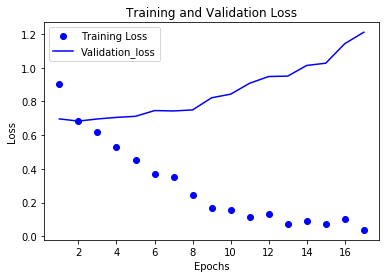

In [54]:
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Making predictions

In [55]:
predictions = model.predict_generator(test_generator,  verbose=1, steps=10)

10/10 [==============================] - 6s 616ms/step


In [56]:
predictions

array([[9.9813449e-01],
       [9.5984304e-01],
       [1.6745631e-05],
       [3.9998120e-01],
       [5.2202362e-01],
       [9.9885511e-01],
       [4.0725698e-03],
       [5.7206732e-01],
       [6.9686666e-02],
       [9.3263894e-01],
       [5.1505929e-01],
       [2.5590954e-04],
       [9.0982872e-01],
       [3.2381974e-03],
       [3.4163466e-01],
       [1.6224986e-01],
       [4.7432999e-03],
       [1.3597548e-01],
       [2.6854603e-02],
       [3.6431506e-01],
       [4.2660418e-01],
       [2.8665212e-01],
       [3.9301503e-01],
       [8.6015619e-02],
       [1.9880309e-04],
       [1.2353596e-03],
       [9.8976034e-01],
       [2.2607535e-01],
       [5.6077832e-01],
       [5.5971125e-04],
       [4.7433388e-01],
       [5.8902144e-01],
       [8.4809037e-03],
       [8.1006682e-01],
       [3.2833104e-05],
       [3.2000476e-01],
       [3.1089509e-01],
       [9.8965710e-01],
       [1.4672840e-01],
       [2.7604946e-01],
       [6.5137851e-01],
       [2.731159

In [57]:
test_loss, test_acc = model.evaluate_generator(test_generator)
print('test acc:', test_acc)

test acc: 0.4651162811489992


In [81]:
test_lossx, test_accx =model_saved.evaluate_generator(test_generator)
print('test acc:', test_accx)

test acc: 0.5813953488372093


In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

In [59]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''This fnctn prints and plots cm, normalization can be applied by setting 'normalize=True'. ''' 
    plt.imshow (cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix Without Normalization')
    print(cm)
    
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment="center", color="white" if cm [i,j]>thresh else "black")
    
    plt.tight_layout
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data Augementation
Setting up a data augmentation configuration via ImageDataGenerator

In [60]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [61]:
from tensorflow.keras.preprocessing import image #Module with imagepreprocessing utilities

fnames = [os.path.join(train_fractures_dir, fname) for 
          fname in os.listdir(train_fractures_dir)]

img_path = fnames[3] #Chooses one image to augment
img = image.load_img(img_path, target_size=(250, 250)) #Reads the image and resizes it

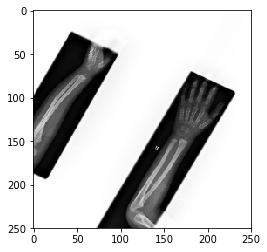

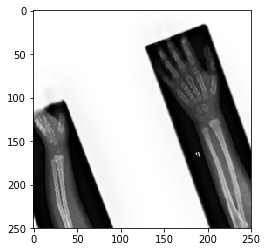

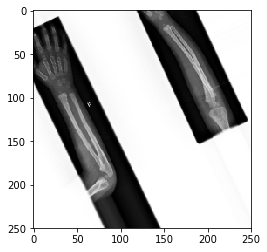

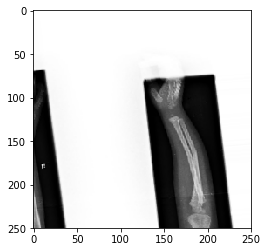

In [62]:
x = image.img_to_array(img) #Converts it to a Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) #Reshapes it to (1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

### Defining a new convnet that includes dropout

In [63]:
augumented_model = models.Sequential()
augumented_model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(250, 250, 3)))
augumented_model.add(layers.MaxPooling2D((2, 2)))

augumented_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
augumented_model.add(layers.MaxPooling2D((2, 2)))

augumented_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
augumented_model.add(layers.MaxPooling2D((2, 2)))

augumented_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
augumented_model.add(layers.MaxPooling2D((2, 2)))

augumented_model.add(layers.Flatten())
augumented_model.add(layers.Dropout(0.5))

augumented_model.add(layers.Dense(512, activation='relu'))
augumented_model.add(layers.Dense(1, activation='sigmoid'))

augumented_model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])


### Training the convnet using data-augmentation generators

In [64]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(250, 250),
                                                    batch_size=10,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(250, 250),
                                                        batch_size=5,
                                                        class_mode='binary')

history = augumented_model.fit_generator(train_generator,
                              steps_per_epoch=15,
                              epochs=40,
                              validation_data=validation_generator,
                              validation_steps=5, callbacks=callbacks_list)


Found 127 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Epoch 1/40
15/15 [==============================] - 37s 2s/step - loss: 0.7137 - acc: 0.4847 - val_loss: 0.6971 - val_acc: 0.4400
Epoch 2/40
15/15 [==============================] - 32s 2s/step - loss: 0.7033 - acc: 0.4893 - val_loss: 0.6956 - val_acc: 0.4400
Epoch 3/40
15/15 [==============================] - 34s 2s/step - loss: 0.6903 - acc: 0.5333 - val_loss: 0.6858 - val_acc: 0.6000
Epoch 4/40
15/15 [==============================] - 31s 2s/step - loss: 0.6998 - acc: 0.4840 - val_loss: 0.6938 - val_acc: 0.4800
Epoch 5/40
15/15 [==============================] - 32s 2s/step - loss: 0.6972 - acc: 0.5067 - val_loss: 0.6932 - val_acc: 0.4800
Epoch 6/40
15/15 [==============================] - 31s 2s/step - loss: 0.6981 - acc: 0.4786 - val_loss: 0.6880 - val_acc: 0.5600
Epoch 7/40
15/15 [==============================] - 33s 2s/step - loss: 0.6910 - acc: 0.4820 - val_loss: 0.6937 - val_acc: 0.4800
Epoch 8/4

In [65]:
augumented_model.save('fractures_and_non_fractures_2_dataaugementation.h5')

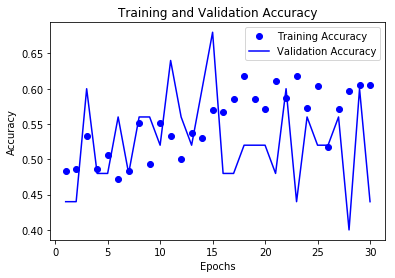

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

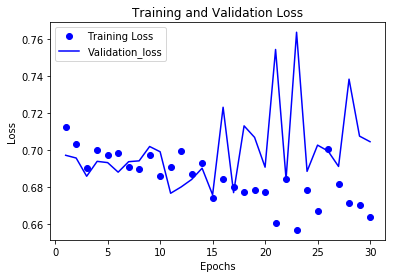

In [67]:
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [68]:
test_loss, test_acc = augumented_model.evaluate_generator(test_generator)
print('test acc:', test_acc)

test acc: 0.5813953599264455


### using pretrained models with vgg architecture

In [69]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

In [70]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

In [73]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 127)
validation_features, validation_labels = extract_features(validation_dir, 41)
test_features, test_labels = extract_features(test_dir, 43)

Found 127 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 43 images belonging to 2 classes.


flatten the shape of the extracted features to format densely connected neurons can accept.

In [74]:
train_features = np.reshape(train_features, (127, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (41, 7 * 7 * 512))
test_features = np.reshape(test_features, (43, 7 * 7 * 512))

In [75]:
train_features

array([[0.13450651, 0.        , 0.        , ..., 0.        , 0.42961553,
        0.        ],
       [1.58290458, 0.        , 0.        , ..., 0.        , 0.44872832,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.74414182,
        0.        ],
       ...,
       [0.04823337, 0.        , 0.        , ..., 0.        , 0.63481605,
        0.        ],
       [0.10182719, 0.        , 0.        , ..., 0.        , 0.23998603,
        0.        ],
       [0.08198991, 0.        , 0.        , ..., 0.        , 0.12411863,
        0.        ]])

### defining and training the densely connected classifier

In [77]:
pmodel = models.Sequential()
pmodel.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
pmodel.add(layers.Dropout(0.5))
pmodel.add(layers.Dense(1, activation='sigmoid'))
pmodel.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy', metrics=['acc'])
phistory = pmodel.fit(train_features, train_labels, epochs=30, batch_size=5,validation_data=(validation_features, validation_labels))

Train on 127 samples, validate on 41 samples
Epoch 1/30
127/127 [==============================] - 4s 32ms/step - loss: 0.8381 - acc: 0.5276 - val_loss: 0.8714 - val_acc: 0.5122
Epoch 2/30
127/127 [==============================] - 3s 23ms/step - loss: 0.7329 - acc: 0.5512 - val_loss: 0.7147 - val_acc: 0.5122
Epoch 3/30
127/127 [==============================] - 3s 22ms/step - loss: 0.6260 - acc: 0.6772 - val_loss: 0.6869 - val_acc: 0.5366
Epoch 4/30
127/127 [==============================] - 3s 22ms/step - loss: 0.5477 - acc: 0.7165 - val_loss: 0.6833 - val_acc: 0.5366
Epoch 5/30
127/127 [==============================] - 3s 24ms/step - loss: 0.5645 - acc: 0.7244 - val_loss: 0.6802 - val_acc: 0.6098
Epoch 6/30
127/127 [==============================] - 3s 23ms/step - loss: 0.4897 - acc: 0.7559 - val_loss: 0.8417 - val_acc: 0.4878
Epoch 7/30
127/127 [==============================] - 3s 23ms/step - loss: 0.4342 - acc: 0.7874 - val_loss: 0.8165 - val_acc: 0.5122
Epoch 8/30
127/127 [====

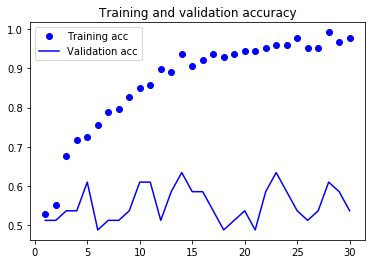

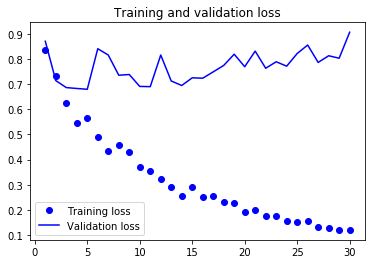

In [82]:
import matplotlib.pyplot as plt
acc = phistory.history['acc']
val_acc = phistory.history['val_acc']
loss = phistory.history['loss']
val_loss = phistory.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [83]:
vgg_model_test_loss, vgg_model_test_acc = pmodel.evaluate(test_features, test_labels)
print('test acc:', vgg_model_test_acc)

43/43 [==============================] - 0s 860us/step
test acc: 0.6744186018788537


In [84]:
pmodel.save('fractures_non_fractures_10_10_2019_vgg.h5')